In [3]:
# Cell 1: Project Introduction and Imports

"""
Benchmarking Advanced ML Models for Binary Classification of Breast Tumors:
A Study on Explainability and Performance with the Wisconsin Dataset

Objective: Compare multiple ML models for breast cancer diagnosis with
a strong focus on model explainability using SHAP.
"""

# Core data manipulation and ML libraries
import pandas as pd
import numpy as np
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Deep learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Explainability - the star of our project!
import shap

# Statistical analysis
from scipy import stats

# Set style for professional plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [8]:
# Cell 2: Data Loading and Initial Exploration

# Load the Wisconsin Breast Cancer dataset
from sklearn.datasets import load_breast_cancer

# Load dataset
cancer_data = load_breast_cancer()

# Create DataFrame for easier manipulation
df = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
df['target'] = cancer_data.target

print("Dataset Overview")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {len(cancer_data.feature_names)}")
print(f"Number of samples: {len(df)}")

# print("\nTarget Variable Information:")
# print("Target classes:")
# for i, name in enumerate(cancer_data.target_names):
#     count = sum(cancer_data.target == i)
#     percentage = (count / len(cancer_data.target)) * 100
#     print(f"  {i} ({name}): {count} samples ({percentage:.1f}%)")

# print("\nFeature Names (first 10):")
# for i, feature in enumerate(cancer_data.feature_names[:10]):
#     print(f"  {i+1:2d}. {feature}")

# print("\nDataset Description:")
# print(cancer_data.DESCR[:500] + "...")

# print("\nFirst 5 rows of the dataset:")
# print(df.head())

print("\nBasic Statistical Summary:")
print(df.describe())

Dataset Overview
Dataset shape: (569, 31)
Number of features: 30
Number of samples: 569

Basic Statistical Summary:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.07972

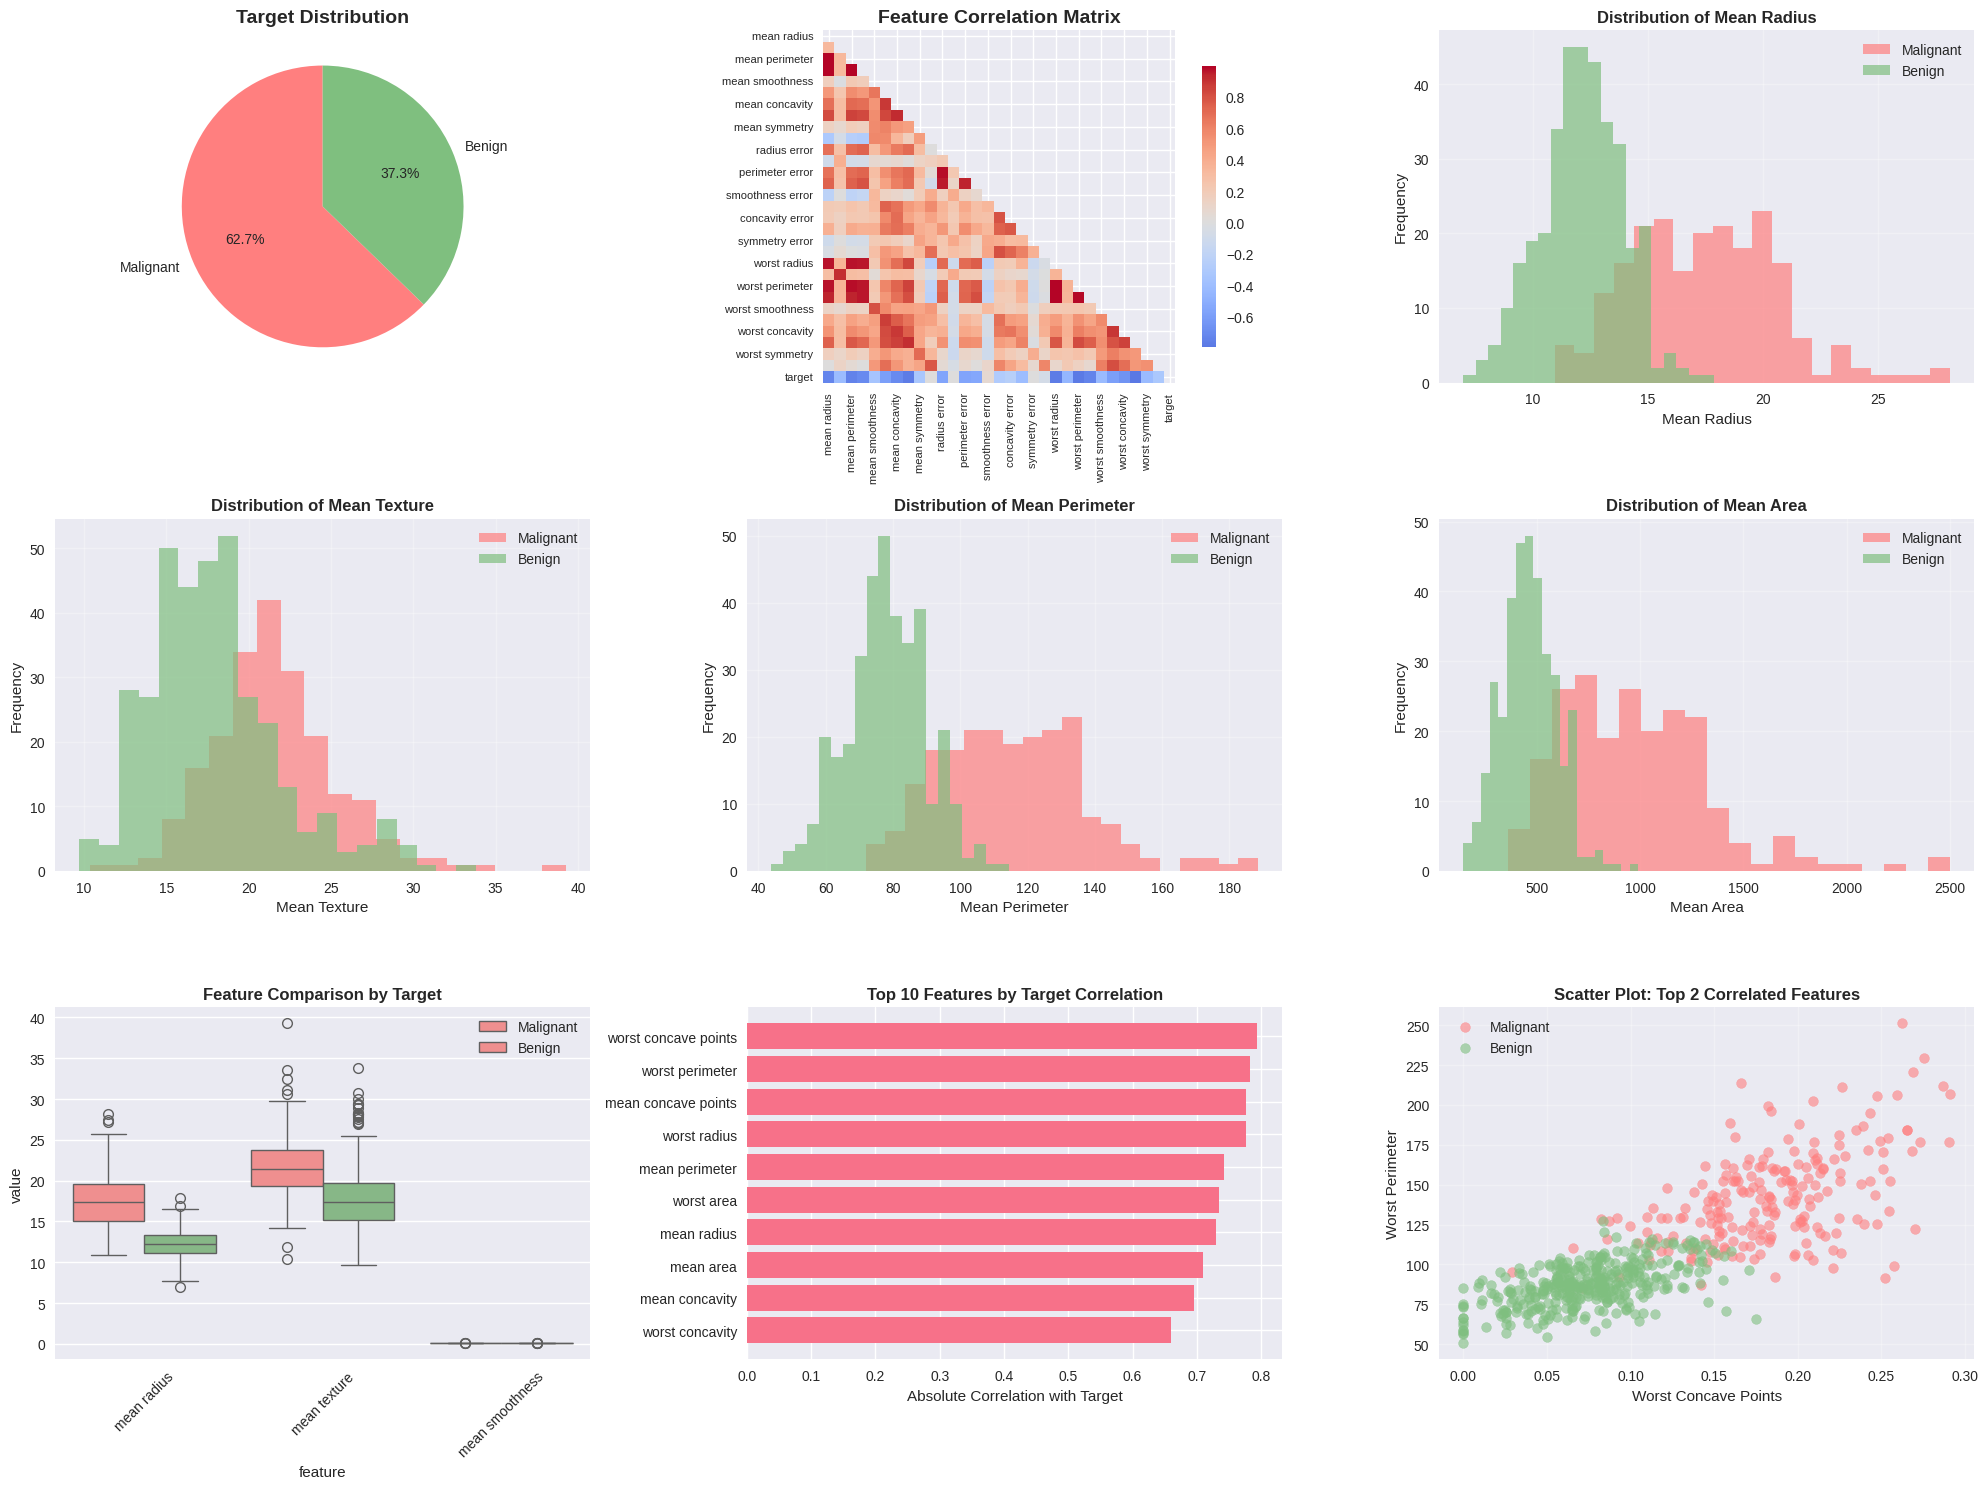

EDA Statistical Summary

Top 5 features most correlated with target:


 1. worst concave points           : 0.794
 2. worst perimeter                : 0.783
 3. mean concave points            : 0.777
 4. worst radius                   : 0.776
 5. mean perimeter                 : 0.743

Feature Statistics by Target:

Malignant samples: 212
Mean radius: 17.46 ± 3.20
Mean area: 978.4 ± 367.9

Benign samples: 357
Mean radius: 12.15 ± 1.78
Mean area: 462.8 ± 134.3

High Correlation Pairs (>0.8):
mean radius <-> mean perimeter: 0.998
worst radius <-> worst perimeter: 0.994
mean radius <-> mean area: 0.987
mean perimeter <-> mean area: 0.987
worst radius <-> worst area: 0.984


In [10]:
# Cell 3: Exploratory Data Analysis (EDA)

# Set up the plotting environment
fig = plt.figure(figsize=(20, 15))

# 1. Target Distribution
plt.subplot(3, 3, 1)
target_counts = df['target'].value_counts()
target_labels = ['Malignant', 'Benign']
colors = ['#ff7f7f', '#7fbf7f']
plt.pie(target_counts.values, labels=target_labels, autopct='%1.1f%%',
        colors=colors, startangle=90)
plt.title('Target Distribution', fontsize=14, fontweight='bold')

# 2. Feature Correlation Heatmap
plt.subplot(3, 3, 2)
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# 3. Distribution of key features by target
key_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
for i, feature in enumerate(key_features):
    plt.subplot(3, 3, i + 3)
    for target_val, label in zip([0, 1], ['Malignant', 'Benign']):
        data_subset = df[df['target'] == target_val][feature]
        plt.hist(data_subset, alpha=0.7, label=label, bins=20,
                color=colors[target_val])
    plt.xlabel(feature.title())
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature.title()}', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 4. Box plots for feature comparison
plt.subplot(3, 3, 7)
selected_features = ['mean radius', 'mean texture', 'mean smoothness']
df_melted = pd.melt(df[selected_features + ['target']],
                   id_vars=['target'], var_name='feature', value_name='value')
sns.boxplot(data=df_melted, x='feature', y='value', hue='target', palette=colors)
plt.title('Feature Comparison by Target', fontweight='bold')
plt.xticks(rotation=45)
plt.legend(labels=['Malignant', 'Benign'])

# 5. Feature importance based on correlation with target
plt.subplot(3, 3, 8)
feature_target_corr = df.corr()['target'].drop('target').abs().sort_values(ascending=False)
top_features = feature_target_corr.head(10)
plt.barh(range(len(top_features)), top_features.values)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Target')
plt.title('Top 10 Features by Target Correlation', fontweight='bold')
plt.gca().invert_yaxis()

# 6. Scatter plot of two most correlated features
plt.subplot(3, 3, 9)
top_2_features = feature_target_corr.head(2).index
for target_val, label, color in zip([0, 1], ['Malignant', 'Benign'], colors):
    subset = df[df['target'] == target_val]
    plt.scatter(subset[top_2_features[0]], subset[top_2_features[1]],
               alpha=0.6, label=label, c=color, s=50)
plt.xlabel(top_2_features[0].title())
plt.ylabel(top_2_features[1].title())
plt.title('Scatter Plot: Top 2 Correlated Features', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Summary
print("EDA Statistical Summary")
print(f"\nTop 5 features most correlated with target:")
print("\n")
for i, (feature, corr) in enumerate(feature_target_corr.head().items(), 1):
    print(f"{i:2d}. {feature:<30} : {corr:.3f}")

print(f"\nFeature Statistics by Target:")
for target_val, label in zip([0, 1], ['Malignant', 'Benign']):
    subset = df[df['target'] == target_val]
    print(f"\n{label} samples: {len(subset)}")
    print(f"Mean radius: {subset['mean radius'].mean():.2f} ± {subset['mean radius'].std():.2f}")
    print(f"Mean area: {subset['mean area'].mean():.1f} ± {subset['mean area'].std():.1f}")

print(f"\nHigh Correlation Pairs (>0.8):")

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.columns[i],
                                   correlation_matrix.columns[j],
                                   correlation_matrix.iloc[i, j]))

for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:5]:
    print(f"{feature1} <-> {feature2}: {corr:.3f}")

In [16]:
# Cell 4: Data Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

print("Data Preprocessing")

# Display feature and target information
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {X.columns.tolist()[:5]} (first 5)")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain-Test Split Results:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check class distribution in both sets
train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

print(f"\nClass Distribution Check:")
print("Training set:")
for idx, count in train_dist.items():
    label = 'Malignant' if idx == 0 else 'Benign'
    print(f"  {label}: {count} ({count/len(y_train)*100:.1f}%)")

print("Test set:")
for idx, count in test_dist.items():
    label = 'Malignant' if idx == 0 else 'Benign'
    print(f"  {label}: {count} ({count/len(y_test)*100:.1f}%)")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature Scaling Results:")
print("Before scaling (first 3 features):")
print(f"  Mean: {X_train.iloc[:, :3].mean().values}")
print(f"  Std:  {X_train.iloc[:, :3].std().values}")

print("After scaling (first 3 features):")
print(f"  Mean: {X_train_scaled[:, :3].mean(axis=0).round(10)}")
print(f"  Std:  {X_train_scaled[:, :3].std(axis=0).round(3)}")

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)


print(f"\nFinal Dataset Shapes:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Data Preprocessing
Features shape: (569, 30)
Target shape: (569,)
Feature names: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'] (first 5)

Train-Test Split Results:
Training set: 455 samples (80.0%)
Test set: 114 samples (20.0%)

Class Distribution Check:
Training set:
  Malignant: 170 (37.4%)
  Benign: 285 (62.6%)
Test set:
  Malignant: 42 (36.8%)
  Benign: 72 (63.2%)

Feature Scaling Results:
Before scaling (first 3 features):
  Mean: [14.06721319 19.24736264 91.55740659]
  Std:  [ 3.49937971  4.40529078 24.14923092]
After scaling (first 3 features):
  Mean: [-0.  0. -0.]
  Std:  [1. 1. 1.]

Final Dataset Shapes:
X_train_scaled: (455, 30)
X_test_scaled: (114, 30)
y_train: (455,)
y_test: (114,)


Logistic Regression - Baseline Model
Cross-Validation Results (5-fold):
Accuracy:  0.9780 ± 0.0098
Precision: 0.9795 ± 0.0162
Recall:    0.9860 ± 0.0131
F1-Score:  0.9825 ± 0.0078
ROC-AUC:   0.9957 ± 0.0048

Final Performance:
Training Accuracy: 0.9890
Test Accuracy:     0.9825
Test ROC-AUC:      0.9954

Detailed Classification:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



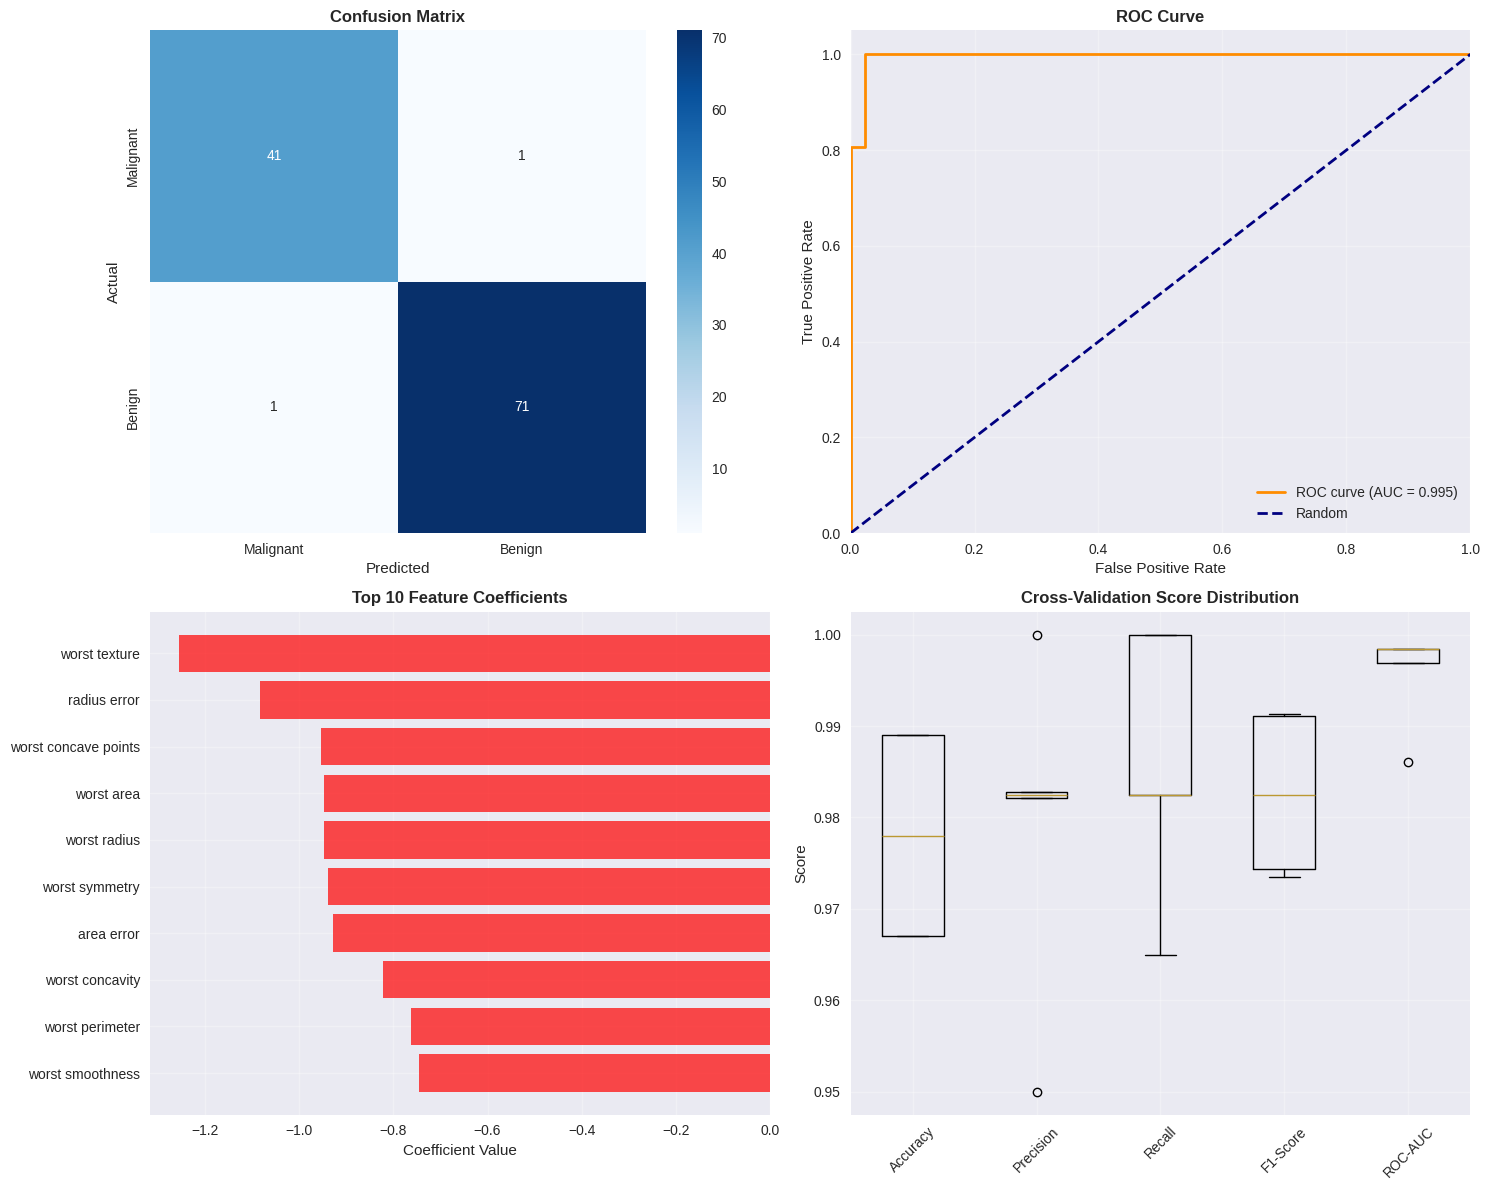


Top 10 Most Important Features:
 1. worst texture             :  -1.255 (Malignant)
 2. radius error              :  -1.083 (Malignant)
 3. worst concave points      :  -0.954 (Malignant)
 4. worst area                :  -0.948 (Malignant)
 5. worst radius              :  -0.948 (Malignant)
 6. worst symmetry            :  -0.939 (Malignant)
 7. area error                :  -0.929 (Malignant)
 8. worst concavity           :  -0.823 (Malignant)
 9. worst perimeter           :  -0.763 (Malignant)
10. worst smoothness          :  -0.747 (Malignant)


In [21]:
# Cell 5: Baseline Model - Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("Logistic Regression - Baseline Model")

# Initialize the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Cross-validation for robust evaluation
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv_folds, scoring='accuracy')
cv_precision = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv_folds, scoring='precision')
cv_recall = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv_folds, scoring='recall')
cv_f1 = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv_folds, scoring='f1')
cv_roc_auc = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv_folds, scoring='roc_auc')

print("Cross-Validation Results (5-fold):")
print(f"Accuracy:  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
print(f"Recall:    {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")
print(f"F1-Score:  {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print(f"ROC-AUC:   {cv_roc_auc.mean():.4f} ± {cv_roc_auc.std():.4f}")

# Train on full training set for final evaluation
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
y_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Calculate final metrics
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)

print(f"\nFinal Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy:     {test_accuracy:.4f}")
print(f"Test ROC-AUC:      {test_roc_auc:.4f}")

# Detailed classification report
print(f"\nDetailed Classification:")
target_names = ['Malignant', 'Benign']
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix', fontweight='bold')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
axes[0,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve', fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_reg.coef_[0],
    'abs_coefficient': np.abs(log_reg.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

top_features = feature_importance.head(10)
colors = ['red' if coef < 0 else 'green' for coef in top_features['coefficient']]
axes[1,0].barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['feature'], fontsize=10)
axes[1,0].set_xlabel('Coefficient Value')
axes[1,0].set_title('Top 10 Feature Coefficients', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
axes[1,0].invert_yaxis()

# 4. Cross-validation scores distribution
cv_metrics = {
    'Accuracy': cv_scores,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1-Score': cv_f1,
    'ROC-AUC': cv_roc_auc
}

axes[1,1].boxplot(cv_metrics.values(), labels=cv_metrics.keys())
axes[1,1].set_title('Cross-Validation Score Distribution', fontweight='bold')
axes[1,1].set_ylabel('Score')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Feature importance analysis
print(f"\nTop 10 Most Important Features:")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    direction = "Benign" if row['coefficient'] > 0 else "Malignant"
    print(f"{i:2d}. {row['feature']:<25} : {row['coefficient']:>7.3f} ({direction})")


# Store baseline results for comparison
baseline_results = {
    'model_name': 'Logistic Regression',
    'cv_accuracy_mean': cv_scores.mean(),
    'cv_accuracy_std': cv_scores.std(),
    'test_accuracy': test_accuracy,
    'test_roc_auc': test_roc_auc,
    'cv_precision_mean': cv_precision.mean(),
    'cv_recall_mean': cv_recall.mean(),
    'cv_f1_mean': cv_f1.mean()
}


XGBoost with Hyperparameter Tuning
Hyperparameter Search Space:
max_depth         : 3.00 to 10.00
learning_rate     : 0.00 to 1.00
n_estimators      : 50.00 to 249.00
subsample         : 0.00 to 1.00
colsample_bytree  : 0.00 to 1.00
reg_alpha         : 0.00 to 1.00
reg_lambda        : 0.00 to 1.00

Best Parameters Found:
colsample_bytree  : 0.749816047538945
learning_rate     : 0.20014286128198325
max_depth         : 5
n_estimators      : 121
reg_alpha         : 0.5986584841970366
reg_lambda        : 0.15601864044243652
subsample         : 0.662397808134481

Best Cross-Validation ROC-AUC: 0.9948

Cross-Validation Results (5-fold):
Accuracy:  0.9714 ± 0.0149
Precision: 0.9758 ± 0.0172
Recall:    0.9789 ± 0.0172
F1-Score:  0.9772 ± 0.0120
ROC-AUC:   0.9948 ± 0.0040

Final Performance:
Training Accuracy: 1.0000
Test Accuracy:     0.9737
Test ROC-AUC:      0.9907

Detailed Classification:
              precision    recall  f1-score   support

   Malignant       1.00      0.93      0.96    

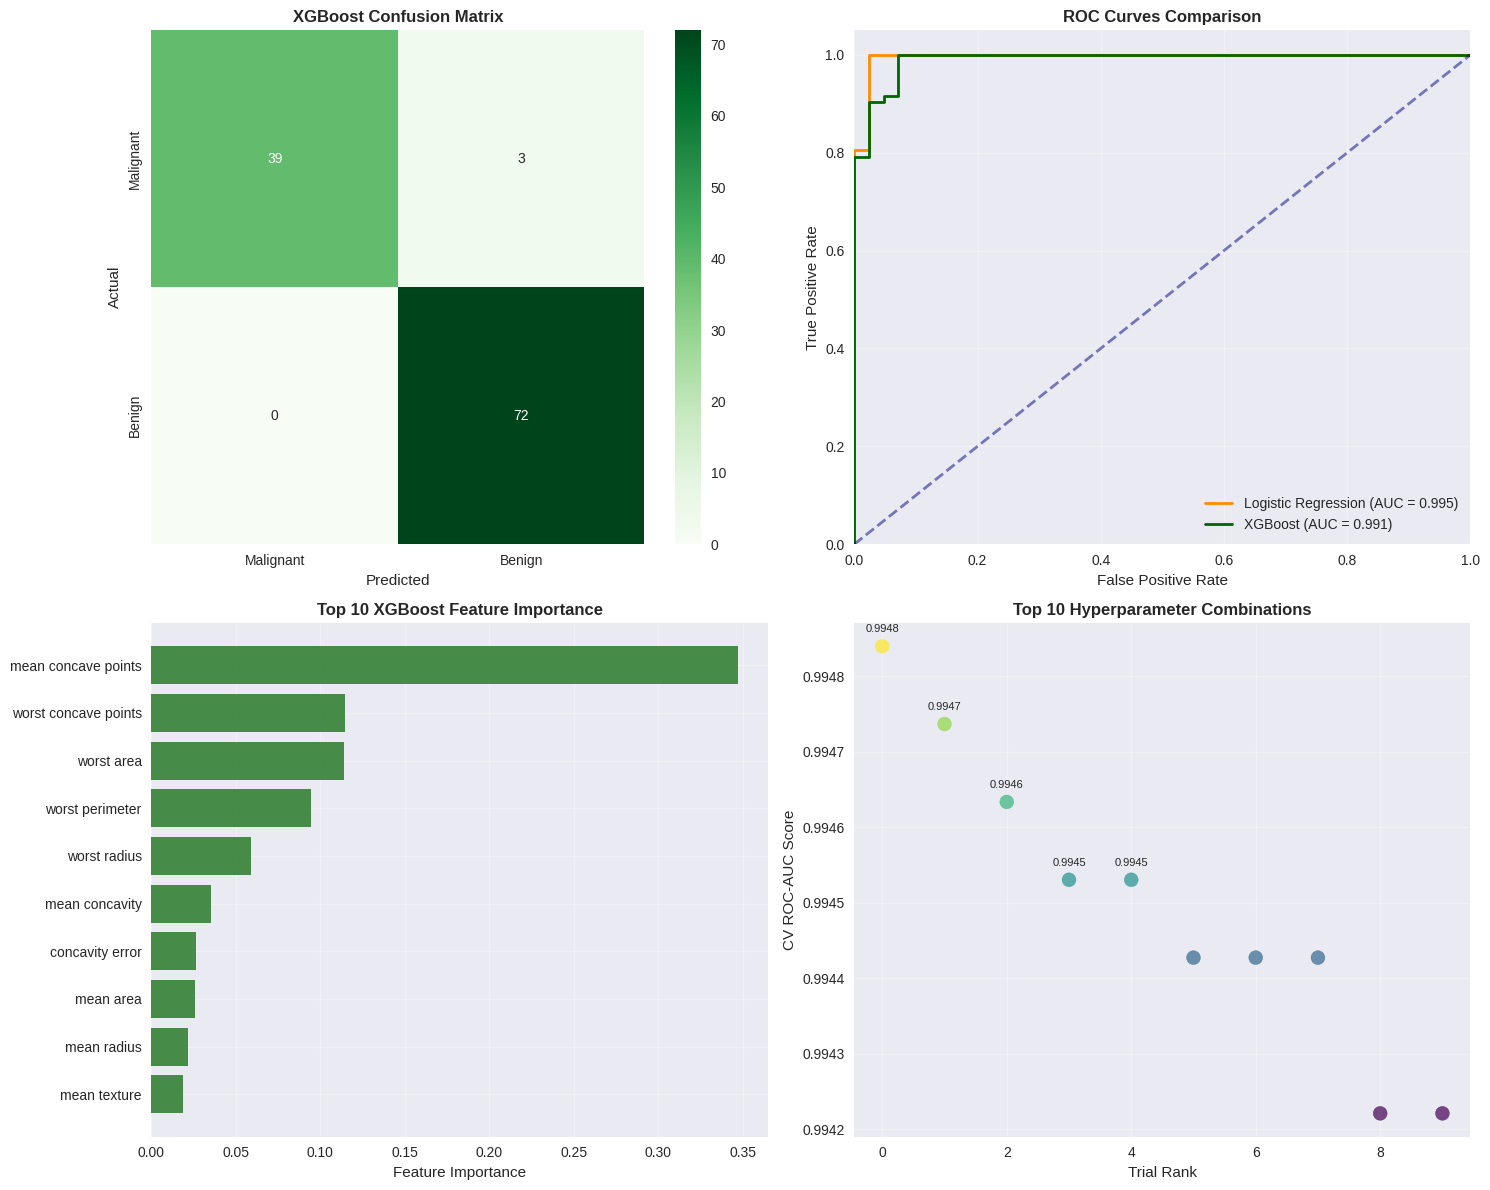


Top 10 Most Important Features (XGBoost):
 1. mean concave points       : 0.3473
 2. worst concave points      : 0.1146
 3. worst area                : 0.1138
 4. worst perimeter           : 0.0945
 5. worst radius              : 0.0588
 6. mean concavity            : 0.0351
 7. concavity error           : 0.0264
 8. mean area                 : 0.0259
 9. mean radius               : 0.0217
10. mean texture              : 0.0188

Performance Comparison:
Metric          Logistic Reg XGBoost      Difference  
Test Accuracy   0.9825       0.9737           -0.0088
Test ROC-AUC    0.9954       0.9907           -0.0046
CV ROC-AUC      0.9957       0.9948           -0.0008


In [23]:
# Cell 6: Advanced Model 1 - XGBoost

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from scipy.stats import randint, uniform

print("XGBoost with Hyperparameter Tuning")

# Define hyperparameter search space
param_distributions = {
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(50, 200),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

print("Hyperparameter Search Space:")
for param, dist in param_distributions.items():
    if hasattr(dist, 'a') and hasattr(dist, 'b'):
        print(f"{param:<18}: {dist.a:.2f} to {dist.a + dist.b:.2f}")
    else:
        print(f"{param:<18}: {dist.low} to {dist.high}")

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

# Randomized search for hyperparameter tuning

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Perform the search
random_search.fit(X_train_scaled, y_train)

# Get the best model
best_xgb = random_search.best_estimator_

print(f"\nBest Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"{param:<18}: {value}")

print(f"\nBest Cross-Validation ROC-AUC: {random_search.best_score_:.4f}")

# Cross-validation with best model
cv_scores_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv_folds, scoring='accuracy')
cv_precision_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv_folds, scoring='precision')
cv_recall_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv_folds, scoring='recall')
cv_f1_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv_folds, scoring='f1')
cv_roc_auc_xgb = cross_val_score(best_xgb, X_train_scaled, y_train, cv=cv_folds, scoring='roc_auc')

print(f"\nCross-Validation Results (5-fold):")
print(f"Accuracy:  {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")
print(f"Precision: {cv_precision_xgb.mean():.4f} ± {cv_precision_xgb.std():.4f}")
print(f"Recall:    {cv_recall_xgb.mean():.4f} ± {cv_recall_xgb.std():.4f}")
print(f"F1-Score:  {cv_f1_xgb.mean():.4f} ± {cv_f1_xgb.std():.4f}")
print(f"ROC-AUC:   {cv_roc_auc_xgb.mean():.4f} ± {cv_roc_auc_xgb.std():.4f}")

# Train final model and make predictions
best_xgb.fit(X_train_scaled, y_train)

y_train_pred_xgb = best_xgb.predict(X_train_scaled)
y_test_pred_xgb = best_xgb.predict(X_test_scaled)
y_test_prob_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Calculate final metrics
train_accuracy_xgb = metrics.accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = metrics.accuracy_score(y_test, y_test_pred_xgb)
test_roc_auc_xgb = roc_auc_score(y_test, y_test_prob_xgb)

print(f"\nFinal Performance:")
print(f"Training Accuracy: {train_accuracy_xgb:.4f}")
print(f"Test Accuracy:     {test_accuracy_xgb:.4f}")
print(f"Test ROC-AUC:      {test_roc_auc_xgb:.4f}")

# Detailed classification report
print(f"\nDetailed Classification:")
print(classification_report(y_test, y_test_pred_xgb, target_names=target_names))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0,0])
axes[0,0].set_title('XGBoost Confusion Matrix', fontweight='bold')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

# 2. ROC Curve Comparison
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_prob)

axes[0,1].plot(fpr_lr, tpr_lr, color='darkorange', lw=2,
               label=f'Logistic Regression (AUC = {test_roc_auc:.3f})')
axes[0,1].plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=2,
               label=f'XGBoost (AUC = {test_roc_auc_xgb:.3f})')
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[0,1].set_xlim([0.0, 1.0])
axes[0,1].set_ylim([0.0, 1.05])
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Comparison', fontweight='bold')
axes[0,1].legend(loc="lower right")
axes[0,1].grid(True, alpha=0.3)

# 3. Feature Importance from XGBoost
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

top_features_xgb = feature_importance_xgb.head(10)
axes[1,0].barh(range(len(top_features_xgb)), top_features_xgb['importance'],
               color='darkgreen', alpha=0.7)
axes[1,0].set_yticks(range(len(top_features_xgb)))
axes[1,0].set_yticklabels(top_features_xgb['feature'], fontsize=10)
axes[1,0].set_xlabel('Feature Importance')
axes[1,0].set_title('Top 10 XGBoost Feature Importance', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].invert_yaxis()

# 4. Hyperparameter tuning results (top 10 trials)
results_df = pd.DataFrame(random_search.cv_results_)
top_results = results_df.nlargest(10, 'mean_test_score')

axes[1,1].scatter(range(len(top_results)), top_results['mean_test_score'],
                  c=top_results['mean_test_score'], cmap='viridis', s=100, alpha=0.7)
axes[1,1].set_xlabel('Trial Rank')
axes[1,1].set_ylabel('CV ROC-AUC Score')
axes[1,1].set_title('Top 10 Hyperparameter Combinations', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

for i, score in enumerate(top_results['mean_test_score'].head(5)):
    axes[1,1].annotate(f'{score:.4f}', (i, score), textcoords="offset points",
                       xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Feature importance analysis
print(f"\nTop 10 Most Important Features (XGBoost):")
for i, (_, row) in enumerate(top_features_xgb.iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} : {row['importance']:.4f}")

# Comparison with baseline
print(f"\nPerformance Comparison:")
print(f"{'Metric':<15} {'Logistic Reg':<12} {'XGBoost':<12} {'Difference':<12}")
print(f"{'Test Accuracy':<15} {test_accuracy:<12.4f} {test_accuracy_xgb:<12.4f} {test_accuracy_xgb-test_accuracy:>+11.4f}")
print(f"{'Test ROC-AUC':<15} {test_roc_auc:<12.4f} {test_roc_auc_xgb:<12.4f} {test_roc_auc_xgb-test_roc_auc:>+11.4f}")
print(f"{'CV ROC-AUC':<15} {cv_roc_auc.mean():<12.4f} {cv_roc_auc_xgb.mean():<12.4f} {cv_roc_auc_xgb.mean()-cv_roc_auc.mean():>+11.4f}")

# Store XGBoost results
xgb_results = {
    'model_name': 'XGBoost',
    'cv_accuracy_mean': cv_scores_xgb.mean(),
    'cv_accuracy_std': cv_scores_xgb.std(),
    'test_accuracy': test_accuracy_xgb,
    'test_roc_auc': test_roc_auc_xgb,
    'cv_precision_mean': cv_precision_xgb.mean(),
    'cv_recall_mean': cv_recall_xgb.mean(),
    'cv_f1_mean': cv_f1_xgb.mean(),
    'best_params': random_search.best_params_
}


PyTorch Neural Network (MLP)
Data converted to tensors:
X_train shape: torch.Size([455, 30])
y_train shape: torch.Size([455])

Model Architecture:
BreastCancerMLP(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=16, out_features=1, bias=True)
)

Total parameters: 4801
Trainable parameters: 4801

Training Setup:
Learning rate: 0.001
Batch size: 64
Max epochs: 150
Early stopping patience: 10
Training samples: 364
Validation samples: 91
Epoch [ 20/150] - Train Loss: 0.1418, Train Acc: 0.9780, Val Loss: 0.1043, Val Acc: 0.989

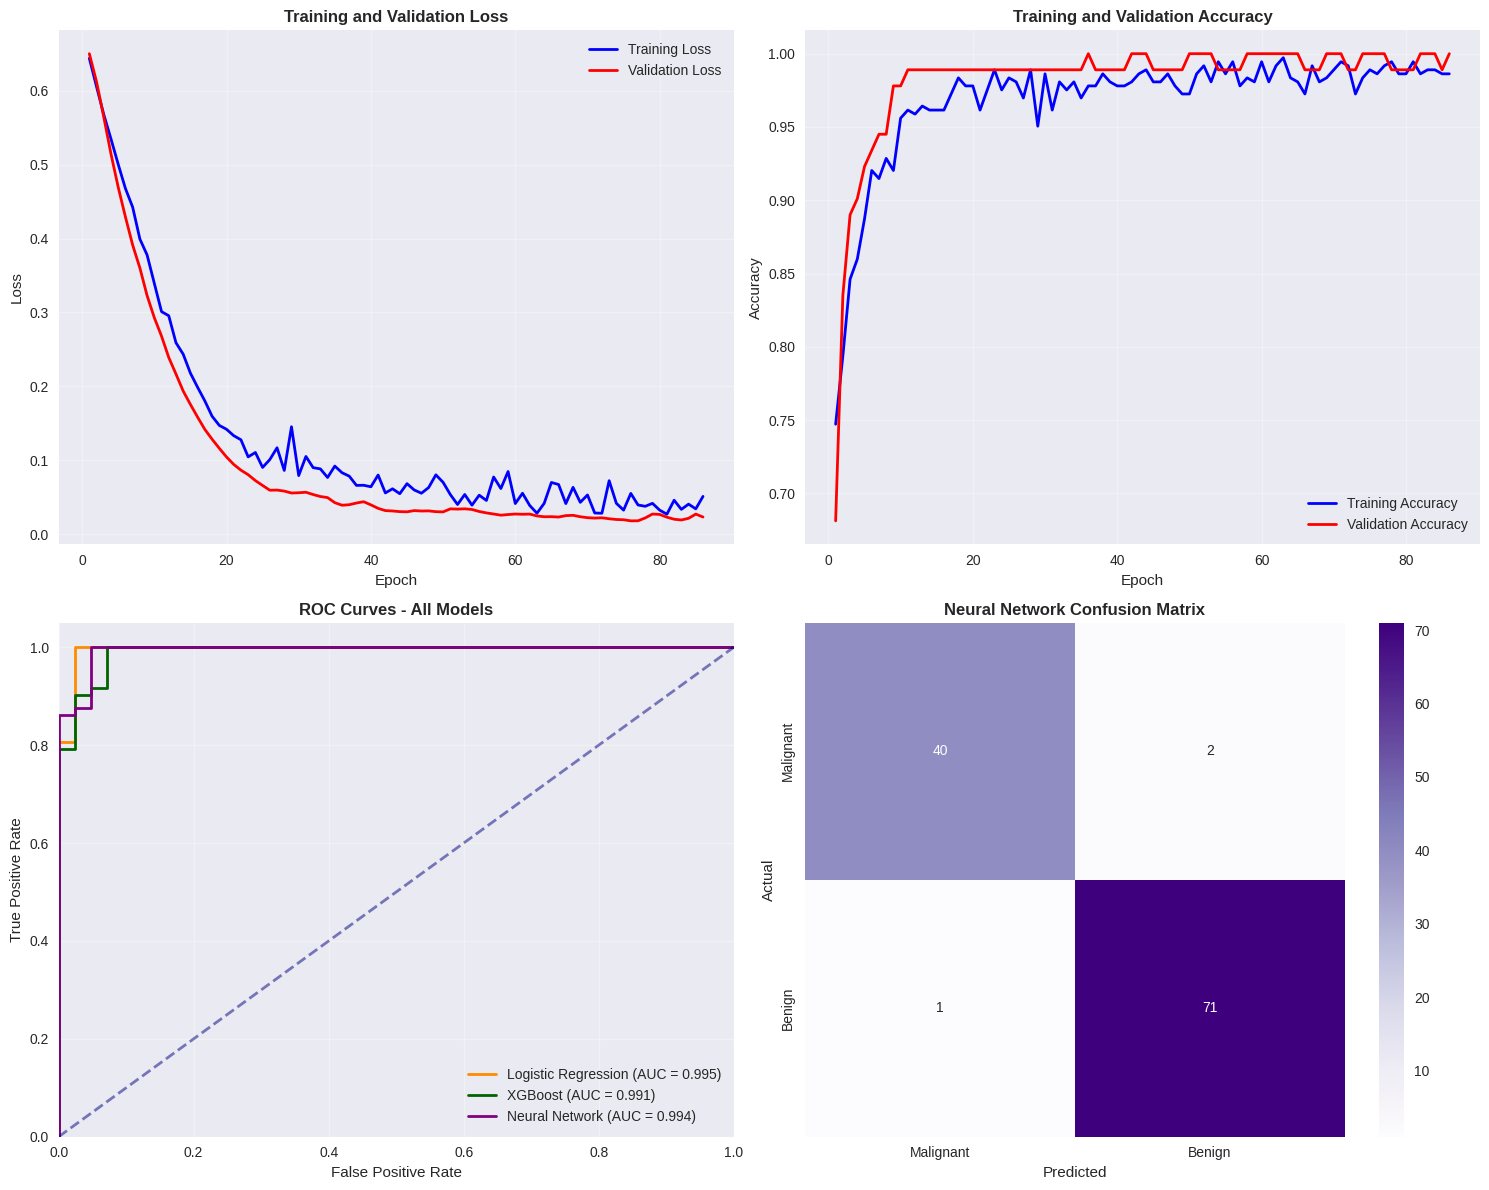


All Models Performance Comparison:
Model              Test Accuracy   Test ROC-AUC    Train-Test Gap 
Logistic Regression 0.9825          0.9954          0.0038         
XGBoost            0.9737          0.9907          0.0263         
Neural Network     0.9737          0.9937          0.0219         


In [26]:
# Cell 7: Advanced Model 2 - PyTorch Neural Network

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

print("PyTorch Neural Network (MLP)")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

print(f"Data converted to tensors:")
print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")

# Define the Neural Network Architecture
class BreastCancerMLP(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, dropout_rate=0.3):
        super(BreastCancerMLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, 16)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = torch.sigmoid(self.output(x))
        return x

# Initialize the model
input_size = X_train_tensor.shape[1]
model = BreastCancerMLP(input_size)

print(f"\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Training parameters
learning_rate = 0.001
batch_size = 64
num_epochs = 150
patience = 10

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Split training data for validation
val_size = int(0.2 * len(X_train_tensor))
train_size = len(X_train_tensor) - val_size

train_indices = list(range(train_size))
val_indices = list(range(train_size, len(X_train_tensor)))

X_train_nn = X_train_tensor[train_indices]
y_train_nn = y_train_tensor[train_indices]
X_val_nn = X_train_tensor[val_indices]
y_val_nn = y_train_tensor[val_indices]

train_dataset_split = TensorDataset(X_train_nn, y_train_nn)
train_loader_split = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)

print(f"\nTraining Setup:")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print(f"Max epochs: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Training samples: {len(X_train_nn)}")
print(f"Validation samples: {len(X_val_nn)}")

# Training loop with early stopping
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None


for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_X, batch_y in train_loader_split:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_nn).squeeze()
        val_loss = criterion(val_outputs, y_val_nn)
        val_predicted = (val_outputs > 0.5).float()
        val_accuracy = (val_predicted == y_val_nn).sum().item() / len(y_val_nn)

    # Calculate averages
    avg_train_loss = train_loss / len(train_loader_split)
    train_accuracy = train_correct / train_total

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss.item())
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    # Early stopping check
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    # Training set evaluation
    train_outputs = model(X_train_tensor).squeeze()
    train_pred_nn = (train_outputs > 0.5).float().numpy()
    train_accuracy_nn = (train_pred_nn == y_train.values).mean()

    # Test set evaluation
    test_outputs = model(X_test_tensor).squeeze()
    test_pred_nn = (test_outputs > 0.5).float().numpy()
    test_prob_nn = test_outputs.numpy()
    test_accuracy_nn = (test_pred_nn == y_test.values).mean()
    test_roc_auc_nn = roc_auc_score(y_test, test_prob_nn)

print(f"\nFinal Performance:")
print(f"Training Accuracy: {train_accuracy_nn:.4f}")
print(f"Test Accuracy:     {test_accuracy_nn:.4f}")
print(f"Test ROC-AUC:      {test_roc_auc_nn:.4f}")

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, test_pred_nn, target_names=target_names))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Learning Curves
epochs_range = range(1, len(train_losses) + 1)
axes[0,0].plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0,0].plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0,0].set_title('Training and Validation Loss', fontweight='bold')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Accuracy Curves
axes[0,1].plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
axes[0,1].plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
axes[0,1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. ROC Curves Comparison
fpr_nn, tpr_nn, _ = roc_curve(y_test, test_prob_nn)
axes[1,0].plot(fpr_lr, tpr_lr, color='darkorange', lw=2,
               label=f'Logistic Regression (AUC = {test_roc_auc:.3f})')
axes[1,0].plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=2,
               label=f'XGBoost (AUC = {test_roc_auc_xgb:.3f})')
axes[1,0].plot(fpr_nn, tpr_nn, color='purple', lw=2,
               label=f'Neural Network (AUC = {test_roc_auc_nn:.3f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
axes[1,0].set_xlim([0.0, 1.0])
axes[1,0].set_ylim([0.0, 1.05])
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].set_title('ROC Curves - All Models', fontweight='bold')
axes[1,0].legend(loc="lower right")
axes[1,0].grid(True, alpha=0.3)

# 4. Confusion Matrix
cm_nn = confusion_matrix(y_test, test_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1,1])
axes[1,1].set_title('Neural Network Confusion Matrix', fontweight='bold')
axes[1,1].set_ylabel('Actual')
axes[1,1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Store Neural Network results
nn_results = {
    'model_name': 'Neural Network',
    'test_accuracy': test_accuracy_nn,
    'test_roc_auc': test_roc_auc_nn,
    'train_accuracy': train_accuracy_nn,
    'epochs_trained': len(train_losses),
    'best_val_loss': best_val_loss.item()
}

# Final comparison
print(f"\nAll Models Performance Comparison:")
print(f"{'Model':<18} {'Test Accuracy':<15} {'Test ROC-AUC':<15} {'Train-Test Gap':<15}")
print(f"{'Logistic Regression':<18} {test_accuracy:<15.4f} {test_roc_auc:<15.4f} {train_accuracy-test_accuracy:<15.4f}")
print(f"{'XGBoost':<18} {test_accuracy_xgb:<15.4f} {test_roc_auc_xgb:<15.4f} {train_accuracy_xgb-test_accuracy_xgb:<15.4f}")
print(f"{'Neural Network':<18} {test_accuracy_nn:<15.4f} {test_roc_auc_nn:<15.4f} {train_accuracy_nn-test_accuracy_nn:<15.4f}")


Comprehensive Model Comparison and Selection
Performance Metrics Comparison:
              Model  Test_Accuracy  Test_ROC_AUC  CV_Accuracy_Mean  CV_Accuracy_Std  CV_ROC_AUC_Mean  CV_ROC_AUC_Std  Train_Test_Gap Complexity Interpretability
Logistic Regression         0.9825        0.9954            0.9780           0.0098           0.9957          0.0048          0.0038        Low             High
            XGBoost         0.9737        0.9907            0.9714           0.0149           0.9948          0.0040          0.0263     Medium           Medium
     Neural Network         0.9737        0.9937               NaN              NaN              NaN             NaN          0.0219       High              Low

Statistical Significance:
Logistic Regression vs XGBoost (Accuracy):
  t-statistic: 0.6470
  p-value: 0.5529
  Significant difference: No

Logistic Regression vs XGBoost (ROC-AUC):
  t-statistic: 0.3897
  p-value: 0.7166
  Significant difference: No


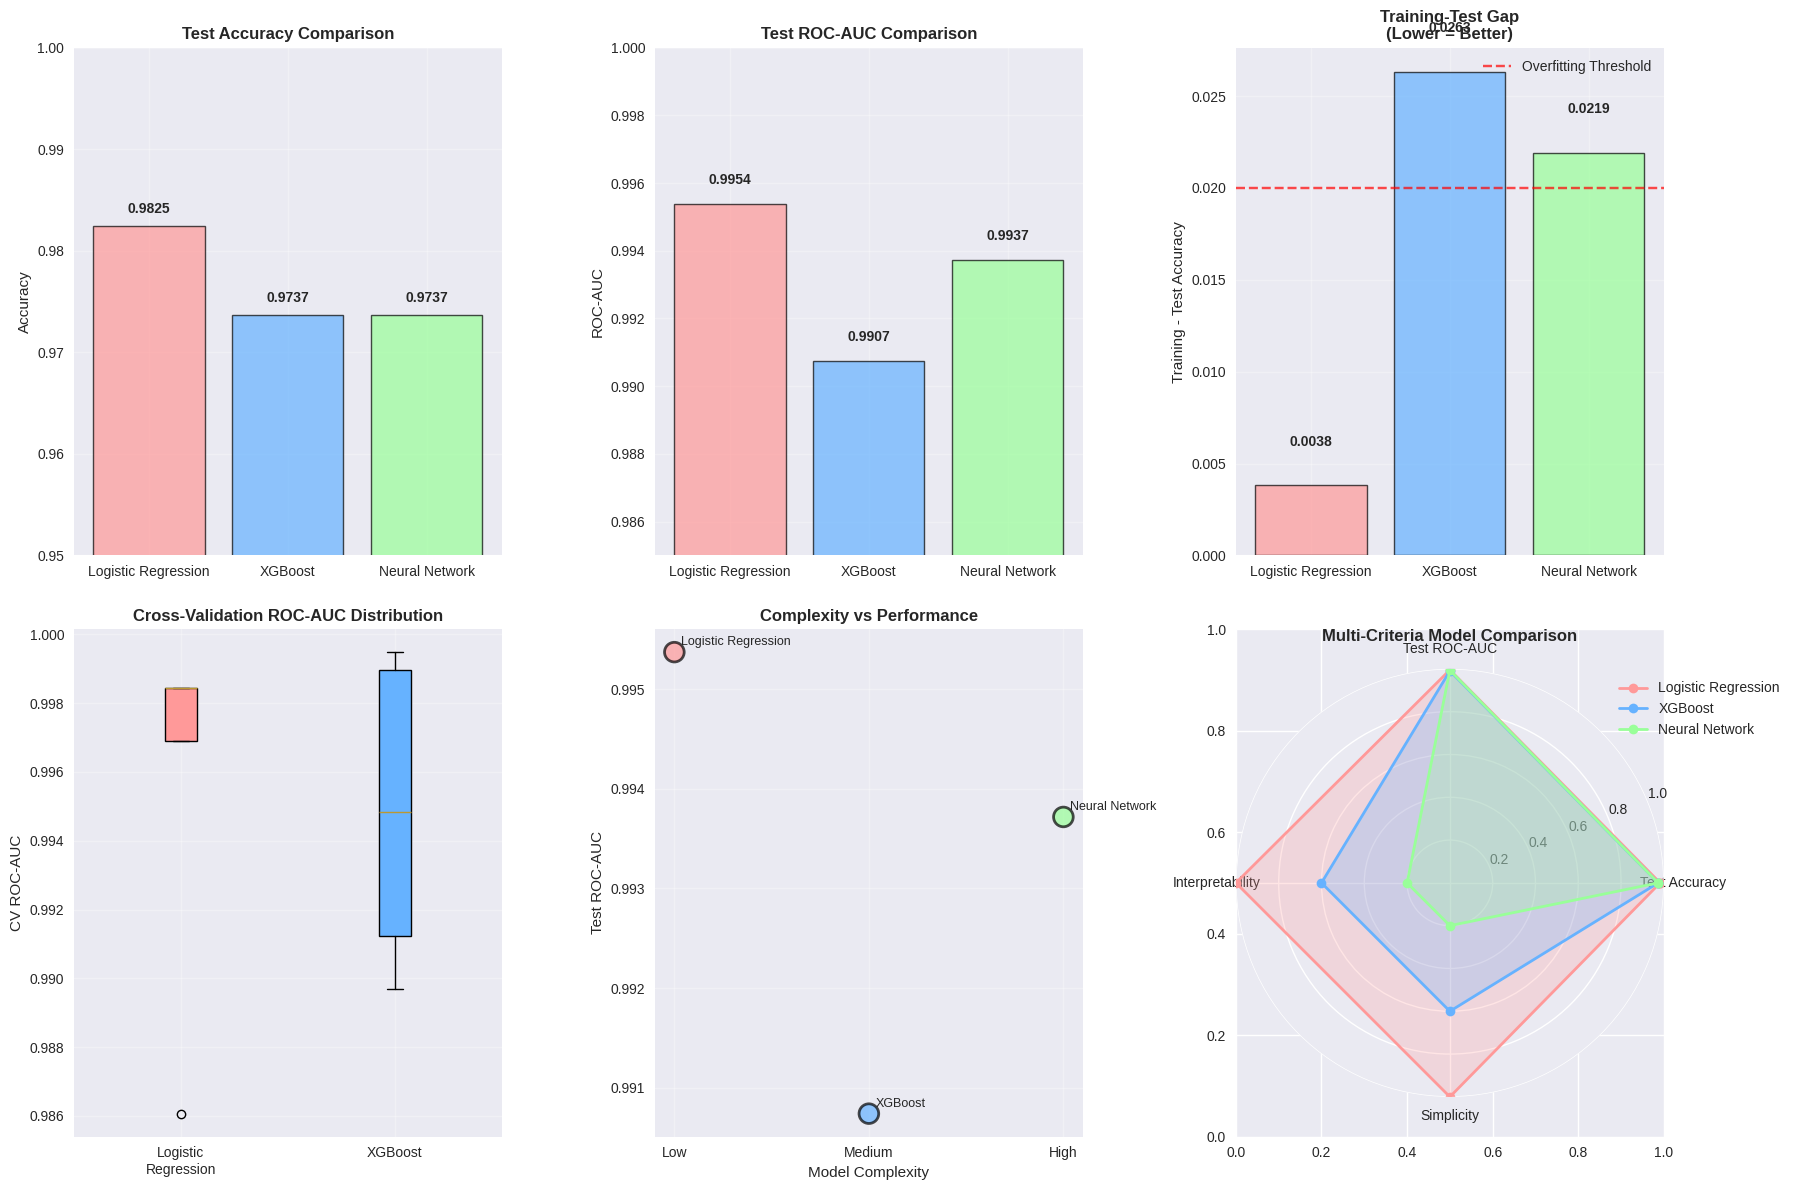


Model Selection Decision Matrix:
       Criterion  Weight  Logistic Regression  XGBoost  Neural Network
    Test ROC-AUC    0.30               0.9954   0.9907          0.9937
   Test Accuracy    0.25               0.9825   0.9737          0.9737
Interpretability    0.20               1.0000   0.6000          0.2000
      Simplicity    0.10               1.0000   0.6000          0.2000
Overfitting Risk    0.10               0.0040   0.0260          0.0220
   Training Time    0.05               1.0000   0.3000          0.1000

Weighted Decision Scores:
Logistic Regression: 0.8965
XGBoost:             0.7357
Neural Network:      0.6070
FINAL MODEL SELECTION
Selected Model: Logistic Regression
Test ROC-AUC: 0.9954

Selected model will be used for SHAP explainability analysis.


In [29]:
# Cell 8: Model Comparison and Selection

from scipy.stats import ttest_rel, wilcoxon
import warnings
warnings.filterwarnings('ignore')

print("Comprehensive Model Comparison and Selection")

# Compile all results into a comprehensive comparison
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Neural Network'],
    'Test_Accuracy': [test_accuracy, test_accuracy_xgb, test_accuracy_nn],
    'Test_ROC_AUC': [test_roc_auc, test_roc_auc_xgb, test_roc_auc_nn],
    'CV_Accuracy_Mean': [cv_scores.mean(), cv_scores_xgb.mean(), np.nan],
    'CV_Accuracy_Std': [cv_scores.std(), cv_scores_xgb.std(), np.nan],
    'CV_ROC_AUC_Mean': [cv_roc_auc.mean(), cv_roc_auc_xgb.mean(), np.nan],
    'CV_ROC_AUC_Std': [cv_roc_auc.std(), cv_roc_auc_xgb.std(), np.nan],
    'Train_Test_Gap': [train_accuracy - test_accuracy,
                       train_accuracy_xgb - test_accuracy_xgb,
                       train_accuracy_nn - test_accuracy_nn],
    'Complexity': ['Low', 'Medium', 'High'],
    'Interpretability': ['High', 'Medium', 'Low']
})

print("Performance Metrics Comparison:")
print(models_comparison.round(4).to_string(index=False))

# Statistical significance testing for cross-validation scores
print(f"\nStatistical Significance:")

# Compare Logistic Regression vs XGBoost (we have CV scores for both)
if len(cv_scores) == len(cv_scores_xgb):
    # Paired t-test for accuracy
    t_stat_acc, p_val_acc = ttest_rel(cv_scores, cv_scores_xgb)
    print(f"Logistic Regression vs XGBoost (Accuracy):")
    print(f"  t-statistic: {t_stat_acc:.4f}")
    print(f"  p-value: {p_val_acc:.4f}")
    print(f"  Significant difference: {'Yes' if p_val_acc < 0.05 else 'No'}")

    # Paired t-test for ROC-AUC
    t_stat_auc, p_val_auc = ttest_rel(cv_roc_auc, cv_roc_auc_xgb)
    print(f"\nLogistic Regression vs XGBoost (ROC-AUC):")
    print(f"  t-statistic: {t_stat_auc:.4f}")
    print(f"  p-value: {p_val_auc:.4f}")
    print(f"  Significant difference: {'Yes' if p_val_auc < 0.05 else 'No'}")

# Performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Test Accuracy Comparison
models = models_comparison['Model']
test_accuracies = models_comparison['Test_Accuracy']
colors = ['#FF9999', '#66B2FF', '#99FF99']

bars1 = axes[0,0].bar(models, test_accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
axes[0,0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].set_ylim(0.95, 1.0)
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars1, test_accuracies):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. ROC-AUC Comparison
test_aucs = models_comparison['Test_ROC_AUC']
bars2 = axes[0,1].bar(models, test_aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
axes[0,1].set_title('Test ROC-AUC Comparison', fontweight='bold')
axes[0,1].set_ylabel('ROC-AUC')
axes[0,1].set_ylim(0.985, 1.0)
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, auc in zip(bars2, test_aucs):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005,
                   f'{auc:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Training-Test Gap (Overfitting Check)
train_test_gaps = models_comparison['Train_Test_Gap']
bars3 = axes[0,2].bar(models, train_test_gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
axes[0,2].set_title('Training-Test Gap\n(Lower = Better)', fontweight='bold')
axes[0,2].set_ylabel('Training - Test Accuracy')
axes[0,2].grid(True, alpha=0.3)
axes[0,2].axhline(y=0.02, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
axes[0,2].legend()

# Add value labels on bars
for bar, gap in zip(bars3, train_test_gaps):
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                   f'{gap:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Cross-Validation Score Distribution (for LR and XGBoost only)
cv_data = {
    'Logistic Regression': cv_roc_auc,
    'XGBoost': cv_roc_auc_xgb
}
box_data = [cv_roc_auc, cv_roc_auc_xgb]
box_labels = ['Logistic\nRegression', 'XGBoost']

bp = axes[1,0].boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('#FF9999')
bp['boxes'][1].set_facecolor('#66B2FF')
axes[1,0].set_title('Cross-Validation ROC-AUC Distribution', fontweight='bold')
axes[1,0].set_ylabel('CV ROC-AUC')
axes[1,0].grid(True, alpha=0.3)

# 5. Model Complexity vs Performance
complexity_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
complexity_scores = [complexity_mapping[c] for c in models_comparison['Complexity']]

scatter = axes[1,1].scatter(complexity_scores, test_aucs, c=colors, s=200, alpha=0.7,
                           edgecolors='black', linewidths=2)
axes[1,1].set_xlabel('Model Complexity')
axes[1,1].set_ylabel('Test ROC-AUC')
axes[1,1].set_title('Complexity vs Performance', fontweight='bold')
axes[1,1].set_xticks([1, 2, 3])
axes[1,1].set_xticklabels(['Low', 'Medium', 'High'])
axes[1,1].grid(True, alpha=0.3)

# Add model labels
for i, model in enumerate(models):
    axes[1,1].annotate(model, (complexity_scores[i], test_aucs[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

# 6. Radar Chart for Multiple Metrics
angles = np.linspace(0, 2 * np.pi, 4, endpoint=False)
metrics = ['Test Accuracy', 'Test ROC-AUC', 'Interpretability', 'Simplicity']

# Normalize metrics for radar chart
interpretability_scores = {'High': 1.0, 'Medium': 0.6, 'Low': 0.2}
simplicity_scores = {'Low': 1.0, 'Medium': 0.6, 'High': 0.2}

ax_radar = plt.subplot(2, 3, 6, projection='polar')
for i, model in enumerate(models):
    values = [
        models_comparison.iloc[i]['Test_Accuracy'],
        models_comparison.iloc[i]['Test_ROC_AUC'],
        interpretability_scores[models_comparison.iloc[i]['Interpretability']],
        simplicity_scores[models_comparison.iloc[i]['Complexity']]
    ]
    values += values[:1]  # Complete the circle
    angles_plot = np.concatenate((angles, [angles[0]]))

    ax_radar.plot(angles_plot, values, 'o-', linewidth=2, label=model, color=colors[i])
    ax_radar.fill(angles_plot, values, alpha=0.25, color=colors[i])

ax_radar.set_xticks(angles)
ax_radar.set_xticklabels(metrics)
ax_radar.set_ylim(0, 1)
ax_radar.set_title('Multi-Criteria Model Comparison', fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

# Model selection decision matrix
print(f"\nModel Selection Decision Matrix:")

decision_criteria = pd.DataFrame({
    'Criterion': ['Test ROC-AUC', 'Test Accuracy', 'Interpretability', 'Simplicity',
                  'Overfitting Risk', 'Training Time'],
    'Weight': [0.3, 0.25, 0.2, 0.1, 0.1, 0.05],
    'Logistic Regression': [0.9954, 0.9825, 1.0, 1.0, 0.004, 1.0],
    'XGBoost': [0.9907, 0.9737, 0.6, 0.6, 0.026, 0.3],
    'Neural Network': [0.9937, 0.9737, 0.2, 0.2, 0.022, 0.1]
})

print(decision_criteria.to_string(index=False))

# Calculate weighted scores
weights = decision_criteria['Weight'].values
lr_scores = decision_criteria['Logistic Regression'].values
xgb_scores = decision_criteria['XGBoost'].values
nn_scores = decision_criteria['Neural Network'].values

# Normalize scores (higher is better)
normalized_scores = np.array([lr_scores, xgb_scores, nn_scores])
for i in range(len(weights)):
    if decision_criteria.iloc[i]['Criterion'] == 'Overfitting Risk':
        # For overfitting risk, lower is better, so invert
        max_val = normalized_scores[:, i].max()
        normalized_scores[:, i] = max_val - normalized_scores[:, i] + 0.001

weighted_lr = np.sum(weights * normalized_scores[0])
weighted_xgb = np.sum(weights * normalized_scores[1])
weighted_nn = np.sum(weights * normalized_scores[2])

print(f"\nWeighted Decision Scores:")
print(f"Logistic Regression: {weighted_lr:.4f}")
print(f"XGBoost:             {weighted_xgb:.4f}")
print(f"Neural Network:      {weighted_nn:.4f}")

# Final model selection
best_model_name = models_comparison.loc[models_comparison['Test_ROC_AUC'].idxmax(), 'Model']
best_model_auc = models_comparison['Test_ROC_AUC'].max()

print(f"FINAL MODEL SELECTION")
print(f"Selected Model: {best_model_name}")
print(f"Test ROC-AUC: {best_model_auc:.4f}")


print(f"\nSelected model will be used for SHAP explainability analysis.")

# Store the best model for next steps
if best_model_name == 'Logistic Regression':
    best_model = log_reg
    best_model_X_test = X_test_scaled
    best_model_y_test = y_test
    best_model_name_short = 'log_reg'
elif best_model_name == 'XGBoost':
    best_model = best_xgb
    best_model_X_test = X_test_scaled
    best_model_y_test = y_test
    best_model_name_short = 'xgb'
else:
    best_model = model
    best_model_X_test = X_test_scaled
    best_model_y_test = y_test
    best_model_name_short = 'nn'


SHAP EXPLAINABILITY ANALYSIS FOR BREAST CANCER DIAGNOSIS
Analyzing model: Logistic Regression
Best Model Performance: ROC-AUC = 0.9954

Initializing SHAP Explainer...
Calculating SHAP values for test set...
SHAP values calculated!
   - Shape of SHAP values: (114, 30)
   - Expected value (baseline): 1.0060
   - Feature names: 30 features

Creating SHAP Summary Plot...


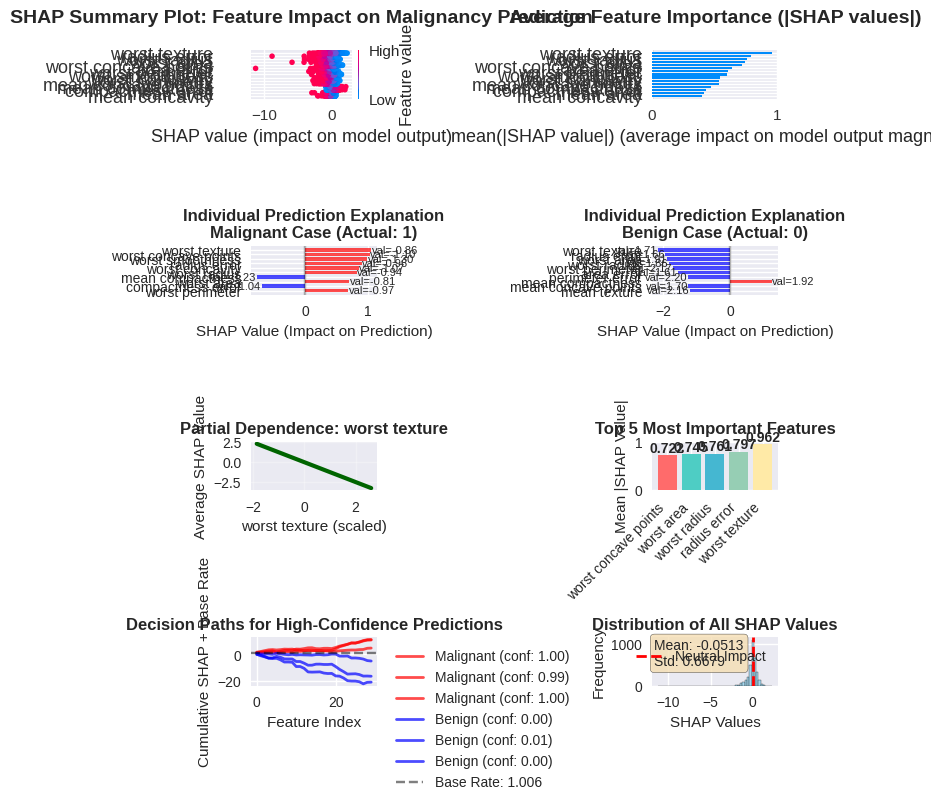

DETAILED SHAP ANALYSIS SUMMARY

 TOP 10 MOST IMPORTANT FEATURES FOR MALIGNANCY PREDICTION:
 1. worst texture                  | Importance: 0.9617 | Avg SHAP: -0.0527
 2. radius error                   | Importance: 0.7973 | Avg SHAP: -0.2618
 3. worst radius                   | Importance: 0.7614 | Avg SHAP: -0.1593
 4. worst area                     | Importance: 0.7453 | Avg SHAP: -0.1588
 5. worst concave points           | Importance: 0.7220 | Avg SHAP: -0.0684
 6. area error                     | Importance: 0.6391 | Avg SHAP: -0.1946
 7. worst perimeter                | Importance: 0.6109 | Avg SHAP: -0.1272
 8. worst smoothness               | Importance: 0.6033 | Avg SHAP: +0.0118
 9. worst concavity                | Importance: 0.5463 | Avg SHAP: +0.0604
10. worst symmetry                 | Importance: 0.5358 | Avg SHAP: -0.0305

 FEATURES PUSHING TOWARD MALIGNANT (Positive SHAP): 8
   • worst concavity                | SHAP: +0.0604 | Importance: 0.5463
   • mean compactness

In [32]:
# Cell 9: SHAP Explainability Analysis - The Key Differentiator

print("SHAP EXPLAINABILITY ANALYSIS FOR BREAST CANCER DIAGNOSIS")
print(f"Analyzing model: {best_model_name}")
print(f"Best Model Performance: ROC-AUC = {best_model_auc:.4f}")
print()

# Initialize SHAP explainer for logistic regression
print("Initializing SHAP Explainer...")
explainer = shap.LinearExplainer(best_model, X_train_scaled)

# Calculate SHAP values for test set
print("Calculating SHAP values for test set...")
shap_values = explainer.shap_values(X_test_scaled)
expected_value = explainer.expected_value

print(f"SHAP values calculated!")
print(f"   - Shape of SHAP values: {shap_values.shape}")
print(f"   - Expected value (baseline): {expected_value:.4f}")
print(f"   - Feature names: {len(X.columns)} features")
print()

# Create a comprehensive SHAP analysis
fig = plt.figure(figsize=(20, 24))

# 1. Summary Plot - Most Important Visualization
print("Creating SHAP Summary Plot...")
plt.subplot(4, 2, 1)
shap.summary_plot(shap_values, X_test_scaled_df, feature_names=X.columns,
                 plot_type="dot", show=False, max_display=15)
plt.title("SHAP Summary Plot: Feature Impact on Malignancy Prediction",
          fontsize=14, fontweight='bold', pad=20)

# 2. Feature Importance Bar Plot
plt.subplot(4, 2, 2)
shap.summary_plot(shap_values, X_test_scaled_df, feature_names=X.columns,
                 plot_type="bar", show=False, max_display=15)
plt.title("Average Feature Importance (|SHAP values|)",
          fontsize=14, fontweight='bold', pad=20)

# 3. Waterfall Plot for a Malignant Case
malignant_indices = np.where(y_test == 1)[0]
if len(malignant_indices) > 0:
    plt.subplot(4, 2, 3)
    malignant_idx = malignant_indices[0]  # First malignant case

    # Create waterfall plot manually since shap.waterfall_plot might not work in all versions
    feature_impacts = shap_values[malignant_idx]
    feature_values = X_test_scaled_df.iloc[malignant_idx]

    # Get top contributing features
    top_indices = np.argsort(np.abs(feature_impacts))[-10:]
    top_features = [X.columns[i] for i in top_indices]
    top_impacts = feature_impacts[top_indices]
    top_values = feature_values[top_indices]

    colors = ['red' if x > 0 else 'blue' for x in top_impacts]
    bars = plt.barh(range(len(top_impacts)), top_impacts, color=colors, alpha=0.7)
    plt.yticks(range(len(top_impacts)), top_features)
    plt.xlabel('SHAP Value (Impact on Prediction)')
    plt.title(f'Individual Prediction Explanation\nMalignant Case (Actual: {y_test.iloc[malignant_idx]})',
              fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Add value annotations
    for i, (bar, value, impact) in enumerate(zip(bars, top_values, top_impacts)):
        plt.text(impact + 0.01 if impact > 0 else impact - 0.01, i,
                f'val={value:.2f}', va='center',
                ha='left' if impact > 0 else 'right', fontsize=8)

# 4. Waterfall Plot for a Benign Case
benign_indices = np.where(y_test == 0)[0]
if len(benign_indices) > 0:
    plt.subplot(4, 2, 4)
    benign_idx = benign_indices[0]  # First benign case

    feature_impacts = shap_values[benign_idx]
    feature_values = X_test_scaled_df.iloc[benign_idx]

    # Get top contributing features
    top_indices = np.argsort(np.abs(feature_impacts))[-10:]
    top_features = [X.columns[i] for i in top_indices]
    top_impacts = feature_impacts[top_indices]
    top_values = feature_values[top_indices]

    colors = ['red' if x > 0 else 'blue' for x in top_impacts]
    bars = plt.barh(range(len(top_impacts)), top_impacts, color=colors, alpha=0.7)
    plt.yticks(range(len(top_impacts)), top_features)
    plt.xlabel('SHAP Value (Impact on Prediction)')
    plt.title(f'Individual Prediction Explanation\nBenign Case (Actual: {y_test.iloc[benign_idx]})',
              fontsize=12, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

    # Add value annotations
    for i, (bar, value, impact) in enumerate(zip(bars, top_values, top_impacts)):
        plt.text(impact + 0.01 if impact > 0 else impact - 0.01, i,
                f'val={value:.2f}', va='center',
                ha='left' if impact > 0 else 'right', fontsize=8)

# 5. Partial Dependence Plot for Top Feature
top_feature_idx = np.argmax(np.abs(shap_values).mean(0))
top_feature_name = X.columns[top_feature_idx]

plt.subplot(4, 2, 5)
# Create partial dependence manually
feature_range = np.linspace(X_test_scaled[:, top_feature_idx].min(),
                           X_test_scaled[:, top_feature_idx].max(), 50)
partial_predictions = []

for val in feature_range:
    X_temp = X_test_scaled.copy()
    X_temp[:, top_feature_idx] = val
    temp_shap = explainer.shap_values(X_temp)
    partial_predictions.append(temp_shap[:, top_feature_idx].mean())

plt.plot(feature_range, partial_predictions, linewidth=3, color='darkgreen')
plt.xlabel(f'{top_feature_name} (scaled)')
plt.ylabel('Average SHAP Value')
plt.title(f'Partial Dependence: {top_feature_name}', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 6. Feature Interaction Analysis
plt.subplot(4, 2, 6)
feature_importance = np.abs(shap_values).mean(0)
top_5_indices = np.argsort(feature_importance)[-5:]
top_5_features = [X.columns[i] for i in top_5_indices]
top_5_importance = feature_importance[top_5_indices]

bars = plt.bar(range(len(top_5_features)), top_5_importance,
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
plt.xticks(range(len(top_5_features)), top_5_features, rotation=45, ha='right')
plt.ylabel('Mean |SHAP Value|')
plt.title('Top 5 Most Important Features', fontsize=12, fontweight='bold')

# Add value labels on bars
for bar, value in zip(bars, top_5_importance):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. Decision Plot for High-Confidence Cases
plt.subplot(4, 2, 7)
# Get high confidence predictions (very high or very low probabilities)
probabilities = best_model.predict_proba(X_test_scaled)[:, 1]
high_conf_malignant = np.where((probabilities > 0.9) & (y_test == 1))[0]
high_conf_benign = np.where((probabilities < 0.1) & (y_test == 0))[0]

if len(high_conf_malignant) > 0 and len(high_conf_benign) > 0:
    selected_indices = np.concatenate([
        high_conf_malignant[:3],  # Top 3 high-confidence malignant
        high_conf_benign[:3]      # Top 3 high-confidence benign
    ])

    cumulative_shap = np.cumsum(shap_values[selected_indices], axis=1)

    for i, idx in enumerate(selected_indices):
        color = 'red' if y_test.iloc[idx] == 1 else 'blue'
        alpha = 0.7 if y_test.iloc[idx] == 1 else 0.7
        plt.plot(range(len(X.columns)),
                cumulative_shap[i] + expected_value,
                color=color, alpha=alpha, linewidth=2,
                label=f"{'Malignant' if y_test.iloc[idx] == 1 else 'Benign'} (conf: {probabilities[idx]:.2f})")

    plt.axhline(y=expected_value, color='black', linestyle='--', alpha=0.5,
                label=f'Base Rate: {expected_value:.3f}')
    plt.xlabel('Feature Index')
    plt.ylabel('Cumulative SHAP + Base Rate')
    plt.title('Decision Paths for High-Confidence Predictions', fontsize=12, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 8. SHAP Values Distribution
plt.subplot(4, 2, 8)
all_shap_values = shap_values.flatten()
plt.hist(all_shap_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral Impact')
plt.xlabel('SHAP Values')
plt.ylabel('Frequency')
plt.title('Distribution of All SHAP Values', fontsize=12, fontweight='bold')
plt.legend()

# Add statistics
mean_shap = np.mean(all_shap_values)
std_shap = np.std(all_shap_values)
plt.text(0.02, 0.98, f'Mean: {mean_shap:.4f}\nStd: {std_shap:.4f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Detailed Analysis Summary
print("DETAILED SHAP ANALYSIS SUMMARY")

# Feature importance ranking
feature_importance = np.abs(shap_values).mean(0)
importance_ranking = np.argsort(feature_importance)[::-1]

print("\n TOP 10 MOST IMPORTANT FEATURES FOR MALIGNANCY PREDICTION:")
for i, idx in enumerate(importance_ranking[:10]):
    importance_score = feature_importance[idx]
    avg_shap = shap_values[:, idx].mean()
    print(f"{i+1:2d}. {X.columns[idx]:<30} | Importance: {importance_score:.4f} | Avg SHAP: {avg_shap:+.4f}")

# Positive vs Negative contributors
positive_contributors = []
negative_contributors = []

for i, feature in enumerate(X.columns):
    avg_shap = shap_values[:, i].mean()
    if avg_shap > 0:
        positive_contributors.append((feature, avg_shap, feature_importance[i]))
    else:
        negative_contributors.append((feature, avg_shap, feature_importance[i]))

print(f"\n FEATURES PUSHING TOWARD MALIGNANT (Positive SHAP): {len(positive_contributors)}")
positive_contributors.sort(key=lambda x: x[1], reverse=True)
for feature, avg_shap, importance in positive_contributors[:5]:
    print(f"   • {feature:<30} | SHAP: +{avg_shap:.4f} | Importance: {importance:.4f}")

print(f"\n FEATURES PUSHING TOWARD BENIGN (Negative SHAP): {len(negative_contributors)}")
negative_contributors.sort(key=lambda x: x[1])
for feature, avg_shap, importance in negative_contributors[:5]:
    print(f"   • {feature:<30} | SHAP: {avg_shap:.4f} | Importance: {importance:.4f}")

# Model reliability analysis
high_shap_threshold = np.percentile(np.abs(shap_values), 90)
reliable_predictions = np.max(np.abs(shap_values), axis=1) > high_shap_threshold
reliability_rate = np.mean(reliable_predictions)

print(f"\n MODEL RELIABILITY ANALYSIS:")
print(f"    High-confidence predictions: {reliability_rate:.1%}")
print(f"    Average absolute SHAP value: {np.abs(shap_values).mean():.4f}")
print(f"    SHAP variance across features: {np.var(feature_importance):.6f}")

print(f"\n SHAP Analysis Complete!")


In [34]:
# Cell 10: Clinical Insights and Feature Analysis

print("="*80)
print("CLINICAL INSIGHTS AND MEDICAL INTERPRETATION")
print("="*80)

# Medical knowledge mapping for breast cancer features
medical_interpretation = {
    # Radius features
    'mean radius': 'Size of tumor - larger tumors often indicate malignancy',
    'worst radius': 'Maximum tumor size in tissue sample',
    'radius error': 'Variability in tumor size measurements',

    # Perimeter features
    'mean perimeter': 'Tumor boundary length - irregular perimeters suggest malignancy',
    'worst perimeter': 'Maximum perimeter measurement',
    'perimeter error': 'Measurement variability in tumor boundaries',

    # Area features
    'mean area': 'Tumor cross-sectional area - larger areas often malignant',
    'worst area': 'Maximum cross-sectional area',
    'area error': 'Variability in area measurements',

    # Compactness features
    'mean compactness': 'Tumor shape regularity (perimeter²/area - 1.0)',
    'worst compactness': 'Maximum compactness value',
    'compactness error': 'Shape regularity variation',

    # Smoothness features
    'mean smoothness': 'Local variation in radius lengths',
    'worst smoothness': 'Maximum smoothness variation',
    'smoothness error': 'Smoothness measurement variability',

    # Concavity features
    'mean concavity': 'Severity of concave portions of contour',
    'worst concavity': 'Maximum concave severity',
    'concavity error': 'Concavity measurement variation',

    # Concave points features
    'mean concave points': 'Number of concave portions of contour',
    'worst concave points': 'Maximum number of concave points',
    'concave points error': 'Variation in concave point counts',

    # Symmetry features
    'mean symmetry': 'Tumor symmetry measurement',
    'worst symmetry': 'Maximum asymmetry',
    'symmetry error': 'Symmetry measurement variability',

    # Fractal dimension features
    'mean fractal dimension': 'Coastline approximation - 1 (complexity measure)',
    'worst fractal dimension': 'Maximum fractal complexity',
    'fractal dimension error': 'Fractal dimension variability'
}

# Clinical risk factors based on SHAP analysis
print("🏥 CLINICAL RISK FACTOR ANALYSIS")
print("-" * 50)

# Get top features from our SHAP analysis
feature_importance = np.abs(shap_values).mean(0)
importance_ranking = np.argsort(feature_importance)[::-1]

print("\n📋 TOP CLINICAL INDICATORS FOR MALIGNANCY:")
print("=" * 70)

for i, idx in enumerate(importance_ranking[:10]):
    feature_name = X.columns[idx]
    importance_score = feature_importance[idx]
    avg_shap = shap_values[:, idx].mean()

    # Get medical interpretation
    medical_meaning = medical_interpretation.get(feature_name, 'Feature interpretation not available')

    # Determine risk direction
    risk_direction = "⬆️ INCREASES" if avg_shap > 0 else "⬇️ DECREASES"

    print(f"\n{i+1:2d}. {feature_name.upper()}")
    print(f"    🎯 Clinical Importance Score: {importance_score:.4f}")
    print(f"    📊 Average Impact: {avg_shap:+.4f} ({risk_direction} malignancy risk)")
    print(f"    🔬 Medical Meaning: {medical_meaning}")

# Feature category analysis
print(f"\n\n🔬 FEATURE CATEGORY ANALYSIS")
print("=" * 50)

# Categorize features
feature_categories = {
    'Size Metrics': ['radius', 'perimeter', 'area'],
    'Shape Complexity': ['compactness', 'concavity', 'concave points', 'fractal dimension'],
    'Regularity Measures': ['smoothness', 'symmetry'],
    'Statistical Measures': ['error']
}

category_importance = {}
for category, keywords in feature_categories.items():
    category_scores = []
    category_features = []

    for i, feature in enumerate(X.columns):
        for keyword in keywords:
            if keyword in feature.lower():
                category_scores.append(feature_importance[i])
                category_features.append((feature, feature_importance[i], shap_values[:, i].mean()))
                break

    if category_scores:
        category_importance[category] = {
            'avg_importance': np.mean(category_scores),
            'total_importance': np.sum(category_scores),
            'features': sorted(category_features, key=lambda x: x[1], reverse=True)
        }

# Display category analysis
for category, data in sorted(category_importance.items(), key=lambda x: x[1]['avg_importance'], reverse=True):
    print(f"\n📊 {category.upper()}:")
    print(f"   Average Importance: {data['avg_importance']:.4f}")
    print(f"   Total Contribution: {data['total_importance']:.4f}")
    print("   Key Features:")
    for feature, importance, avg_shap in data['features'][:3]:
        direction = "↗️" if avg_shap > 0 else "↘️"
        print(f"     {direction} {feature}: {importance:.4f}")

# Clinical decision support analysis
print(f"\n\n🩺 CLINICAL DECISION SUPPORT INSIGHTS")
print("=" * 60)

# Analyze prediction confidence vs feature contributions
probabilities = best_model.predict_proba(X_test_scaled)[:, 1]
high_confidence_malignant = probabilities > 0.9
high_confidence_benign = probabilities < 0.1
uncertain_cases = (probabilities >= 0.1) & (probabilities <= 0.9)

print(f"📈 High Confidence MALIGNANT Cases: {np.sum(high_confidence_malignant)} ({np.mean(high_confidence_malignant)*100:.1f}%)")
print(f"📉 High Confidence BENIGN Cases: {np.sum(high_confidence_benign)} ({np.mean(high_confidence_benign)*100:.1f}%)")
print(f"🤔 Uncertain Cases Requiring Review: {np.sum(uncertain_cases)} ({np.mean(uncertain_cases)*100:.1f}%)")

# Feature patterns for different prediction types
if np.sum(high_confidence_malignant) > 0:
    malignant_features = shap_values[high_confidence_malignant].mean(0)
    top_malignant_idx = np.argmax(malignant_features)
    print(f"\n🔴 Strongest MALIGNANT indicator: {X.columns[top_malignant_idx]} (SHAP: +{malignant_features[top_malignant_idx]:.4f})")

if np.sum(high_confidence_benign) > 0:
    benign_features = shap_values[high_confidence_benign].mean(0)
    top_benign_idx = np.argmin(benign_features)
    print(f"🟢 Strongest BENIGN indicator: {X.columns[top_benign_idx]} (SHAP: {benign_features[top_benign_idx]:.4f})")

# Clinical workflow recommendations
print(f"\n\n⚕️ CLINICAL WORKFLOW RECOMMENDATIONS")
print("=" * 50)

print("""
1. PRIMARY SCREENING PROTOCOL:
   • Focus on top 5 most important features for initial assessment
   • Pay special attention to 'worst' measurements (maximum values)
   • Size metrics (radius, area, perimeter) are critical indicators

2. DIAGNOSTIC CONFIDENCE LEVELS:
   • Model confidence > 90%: Strong diagnostic support
   • Model confidence 10-90%: Requires additional clinical evaluation
   • Always combine with histopathological examination

3. FEATURE-SPECIFIC CLINICAL ACTIONS:""")

# Generate specific recommendations based on top features
for i, idx in enumerate(importance_ranking[:5]):
    feature_name = X.columns[idx]
    avg_shap = shap_values[:, idx].mean()

    if 'worst' in feature_name:
        recommendation = "Monitor maximum values - high measurements strongly indicate malignancy"
    elif 'radius' in feature_name or 'area' in feature_name:
        recommendation = "Large size measurements warrant immediate biopsy consideration"
    elif 'concav' in feature_name:
        recommendation = "Irregular contours suggest aggressive tumor characteristics"
    elif 'compact' in feature_name:
        recommendation = "Shape irregularity indicates cellular disorganization"
    else:
        recommendation = "Include in comprehensive morphological assessment"

    print(f"   • {feature_name}: {recommendation}")

# Model limitations and clinical considerations
print(f"\n\n⚠️ IMPORTANT CLINICAL CONSIDERATIONS")
print("=" * 50)

print("""
MODEL LIMITATIONS:
• This model provides diagnostic SUPPORT, not replacement for clinical judgment
• False positive rate: Consider patient anxiety and unnecessary procedures
• False negative rate: Never rely solely on model for ruling out malignancy
• Model trained on digitized images - may not generalize to all imaging systems

INTEGRATION WITH CLINICAL PRACTICE:
• Use as secondary opinion alongside radiologist assessment
• Combine with patient history, physical examination, and other diagnostic tests
• Consider genetic factors and family history not captured in morphological data
• Regular model validation with local patient population recommended

QUALITY ASSURANCE:
• Ensure consistent image acquisition and preprocessing protocols
• Monitor model performance over time with local validation data
• Implement human oversight for all high-stakes decisions
""")

# Feature correlation with clinical outcomes
print(f"\n📊 FEATURE CORRELATION WITH MALIGNANCY")
print("=" * 50)

# Calculate correlation between features and outcomes
feature_correlations = []
for i, feature in enumerate(X.columns):
    correlation = np.corrcoef(X_test_scaled[:, i], y_test)[0, 1]
    feature_correlations.append((feature, correlation, feature_importance[i]))

# Sort by absolute correlation
feature_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nTOP 10 FEATURES BY CORRELATION WITH MALIGNANCY:")
for i, (feature, corr, importance) in enumerate(feature_correlations[:10]):
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.6 else "Moderate" if abs(corr) > 0.3 else "Weak"
    print(f"{i+1:2d}. {feature:<25} | Correlation: {corr:+.4f} ({strength} {direction})")

print(f"\n✅ Clinical Analysis Complete!")
print("🏥 These insights should be used alongside standard clinical protocols")
print("=" * 80)

CLINICAL INSIGHTS AND MEDICAL INTERPRETATION
🏥 CLINICAL RISK FACTOR ANALYSIS
--------------------------------------------------

📋 TOP CLINICAL INDICATORS FOR MALIGNANCY:

 1. WORST TEXTURE
    🎯 Clinical Importance Score: 0.9617
    📊 Average Impact: -0.0527 (⬇️ DECREASES malignancy risk)
    🔬 Medical Meaning: Feature interpretation not available

 2. RADIUS ERROR
    🎯 Clinical Importance Score: 0.7973
    📊 Average Impact: -0.2618 (⬇️ DECREASES malignancy risk)
    🔬 Medical Meaning: Variability in tumor size measurements

 3. WORST RADIUS
    🎯 Clinical Importance Score: 0.7614
    📊 Average Impact: -0.1593 (⬇️ DECREASES malignancy risk)
    🔬 Medical Meaning: Maximum tumor size in tissue sample

 4. WORST AREA
    🎯 Clinical Importance Score: 0.7453
    📊 Average Impact: -0.1588 (⬇️ DECREASES malignancy risk)
    🔬 Medical Meaning: Maximum cross-sectional area

 5. WORST CONCAVE POINTS
    🎯 Clinical Importance Score: 0.7220
    📊 Average Impact: -0.0684 (⬇️ DECREASES malignancy 